En este archivo vamos a clasificar de forma profunda,clasterizar los datos y realizar una serie temporal:

Primero vamos a importar las librerías necesarias

In [71]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MeanShift, MiniBatchKMeans, DBSCAN, OPTICS
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sklearn.impute import SimpleImputer

Ahora cargamos los datos:

In [72]:
df_2017 = pd.read_csv('data/champions-league-2017.csv')
df_2018 = pd.read_csv('data/champions-league-2018.csv')
df_2019 = pd.read_csv('data/champions-league-2019.csv')
df_2020 = pd.read_csv('data/champions-league-2020.csv')
df_2021 = pd.read_csv('data/champions-league-2021.csv')
df_2022 = pd.read_csv('data/champions-league-2022.csv')

df_equipos_goles = pd.read_csv('data/equipos-goles.csv')
df_uefa_ranking = pd.read_csv('data/UEFA_Ranking.csv')
df_victorias = pd.read_csv('data/victorias.csv')
df_champions = pd.read_csv('data/champions_wins.csv')

Primero vamos a ver que conseguimos sacar clusterizando cada champions pasada hasta el 2017

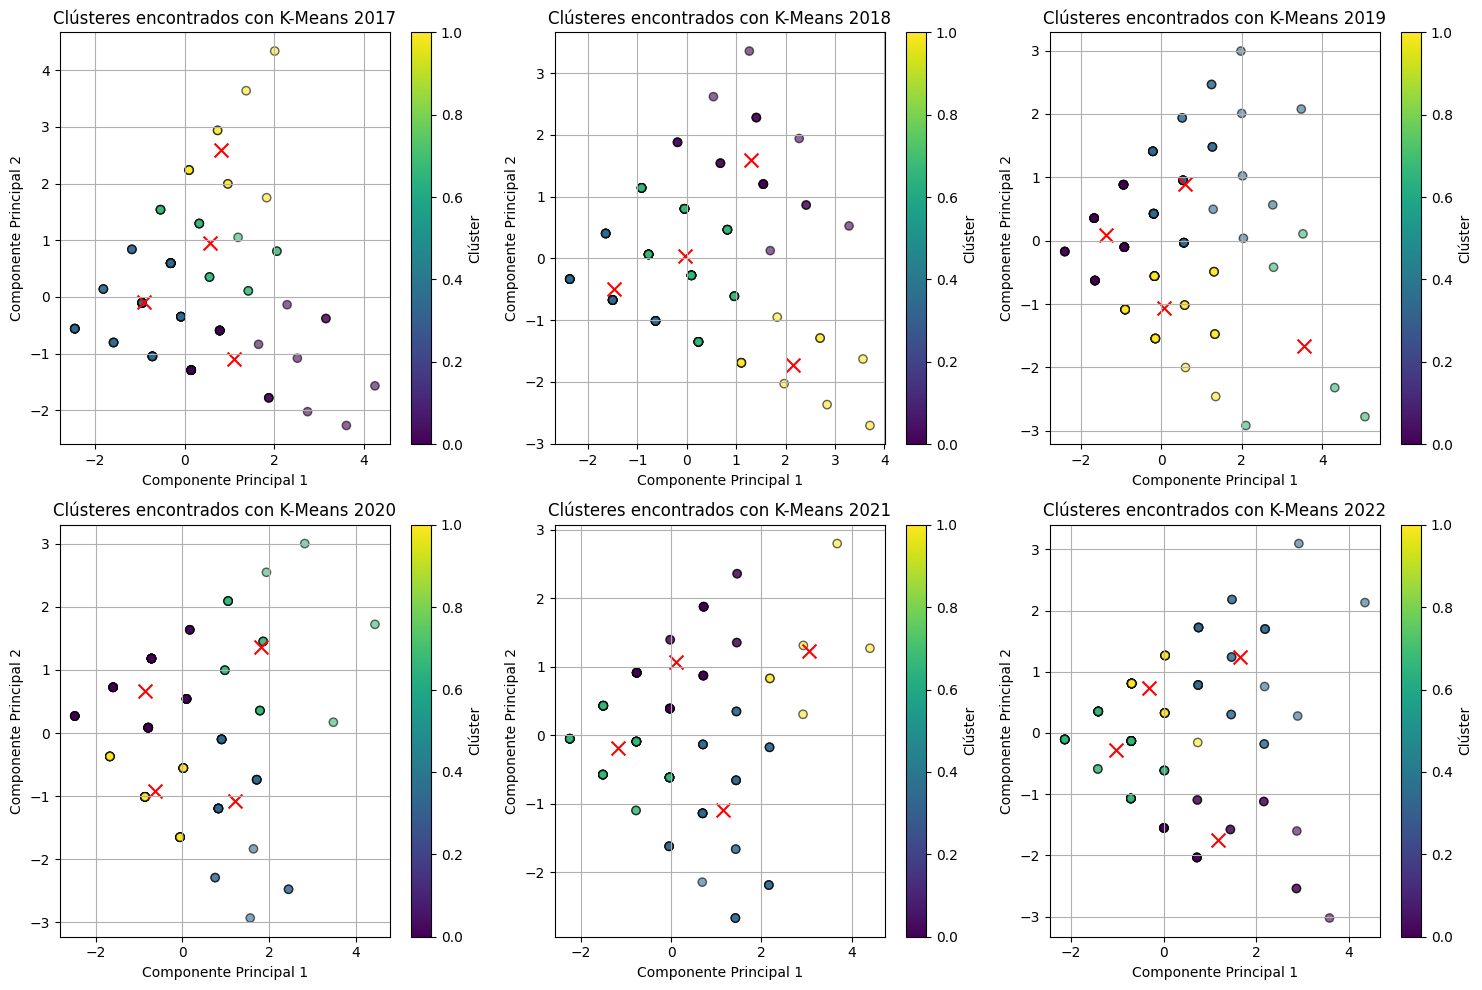

In [73]:
# Lista de DataFrames
csvs = [df_2017, df_2018, df_2019, df_2020, df_2021, df_2022]

# Crear una nueva figura
plt.figure(figsize=(15, 10))

# Iterar sobre cada DataFrame
for i, df in enumerate(csvs, start=1):
    # Eliminar columnas no numéricas o no relevantes para PCA
    df_numeric = df.drop(columns=['Match Number', 'Round Number', 'Result', 'Winner', 'Home Team', 'Away Team'])

    # Escalar características numéricas
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df_numeric)

    # Reducción de dimensionalidad con PCA
    pca = PCA(n_components=2)
    df_pca = pca.fit_transform(df_scaled)

    # Clústering con K-Means
    kmeans = KMeans(n_clusters=4)
    kmeans.fit(df_pca)
    labels = kmeans.labels_

    # Posicionamiento de la sub-figura
    plt.subplot(2, 3, i)
    
    # Visualización de resultados
    plt.scatter(df_pca[:, 0], df_pca[:, 1], c=labels, cmap='viridis', edgecolor='k', alpha=0.6)
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='x', s=100)
    plt.title(f'Clústeres encontrados con K-Means {i+2016}')
    plt.xlabel('Componente Principal 1')
    plt.ylabel('Componente Principal 2')
    plt.colorbar(label='Clúster')
    plt.grid(True)

# Ajustar el diseño
plt.tight_layout()

# Mostrar la figura
plt.show()

Ahora vamos a probar a hacer el clustering según otros algoritmos como Mean_Shift, Mini-Batch K-Means, DBScans, OPTICS, GMM, Agglomerative Clustering:

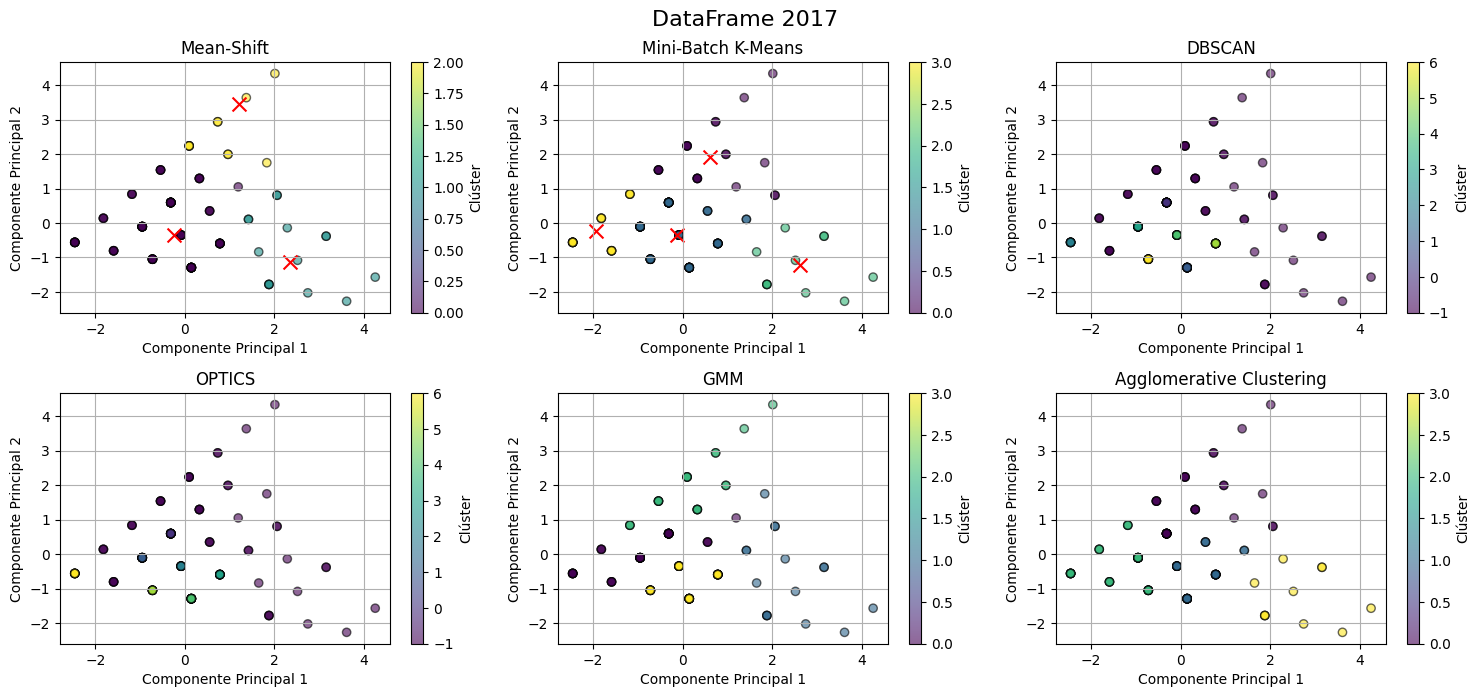

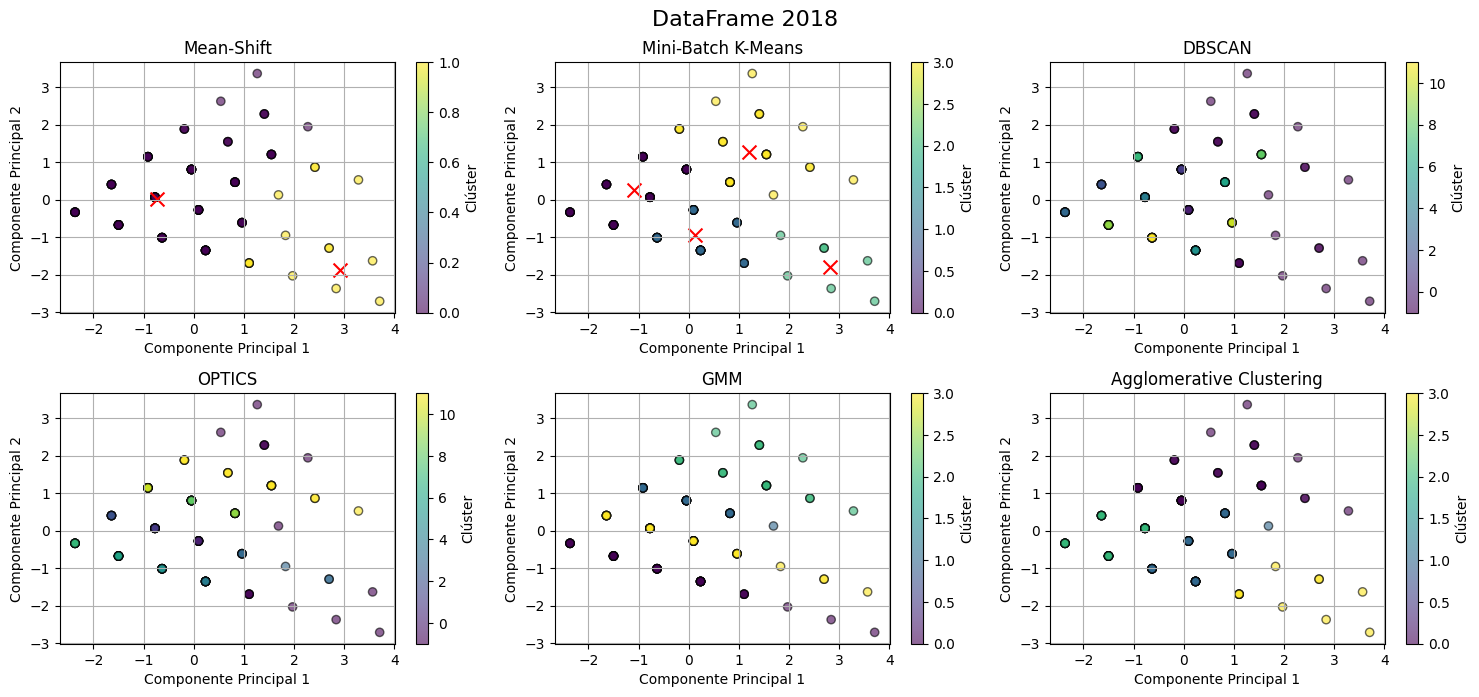

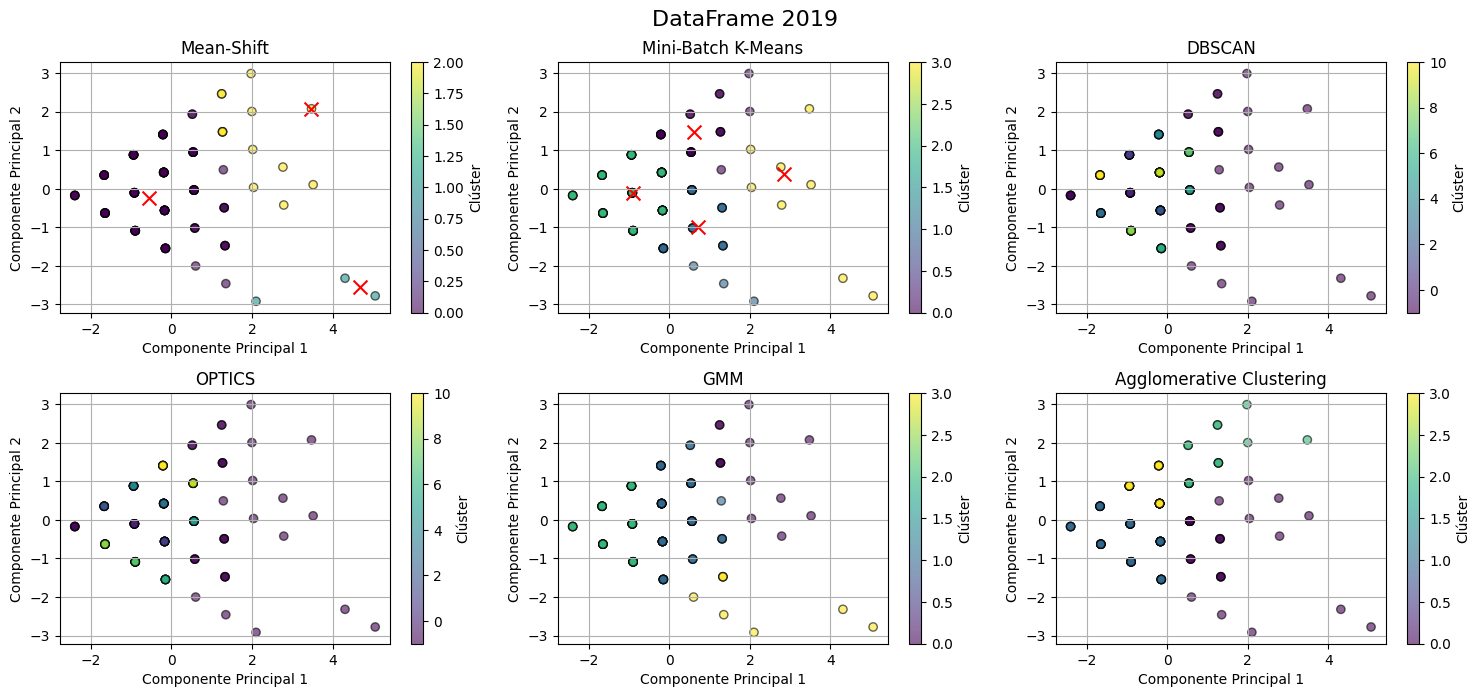

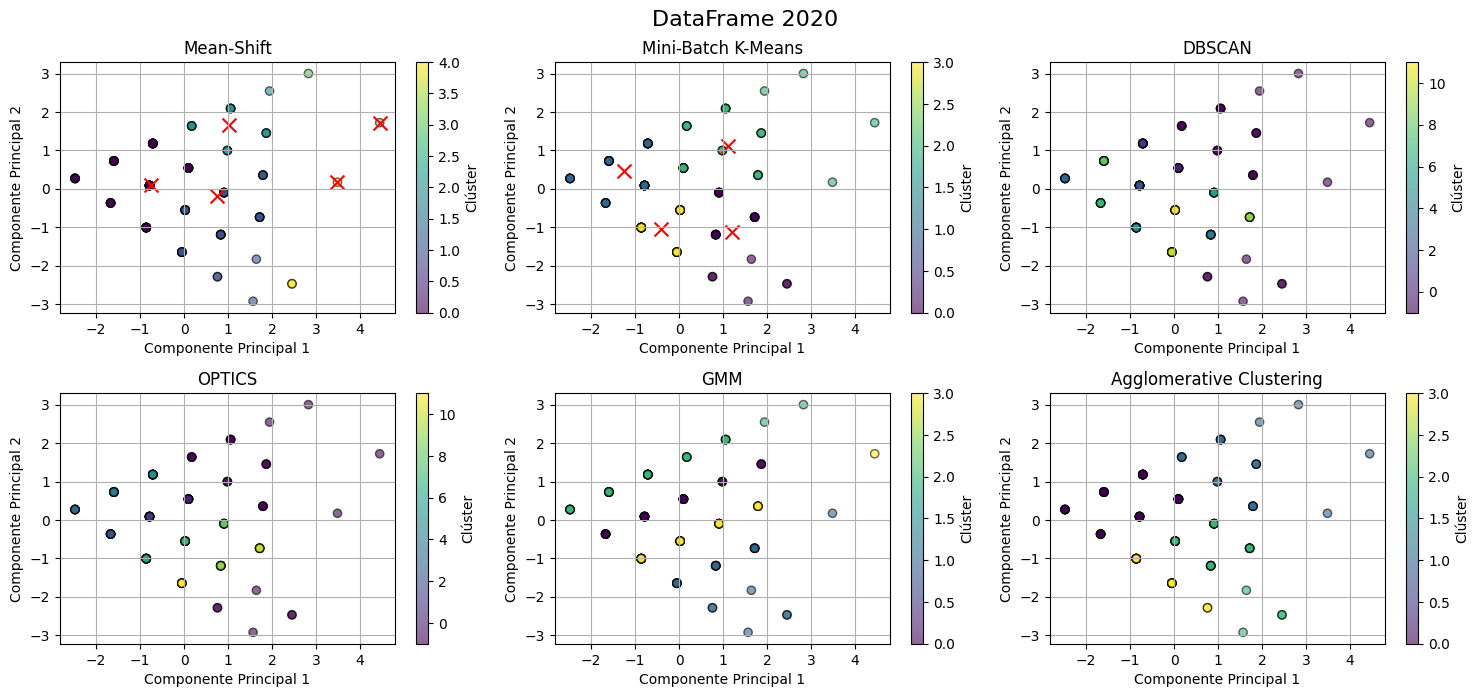

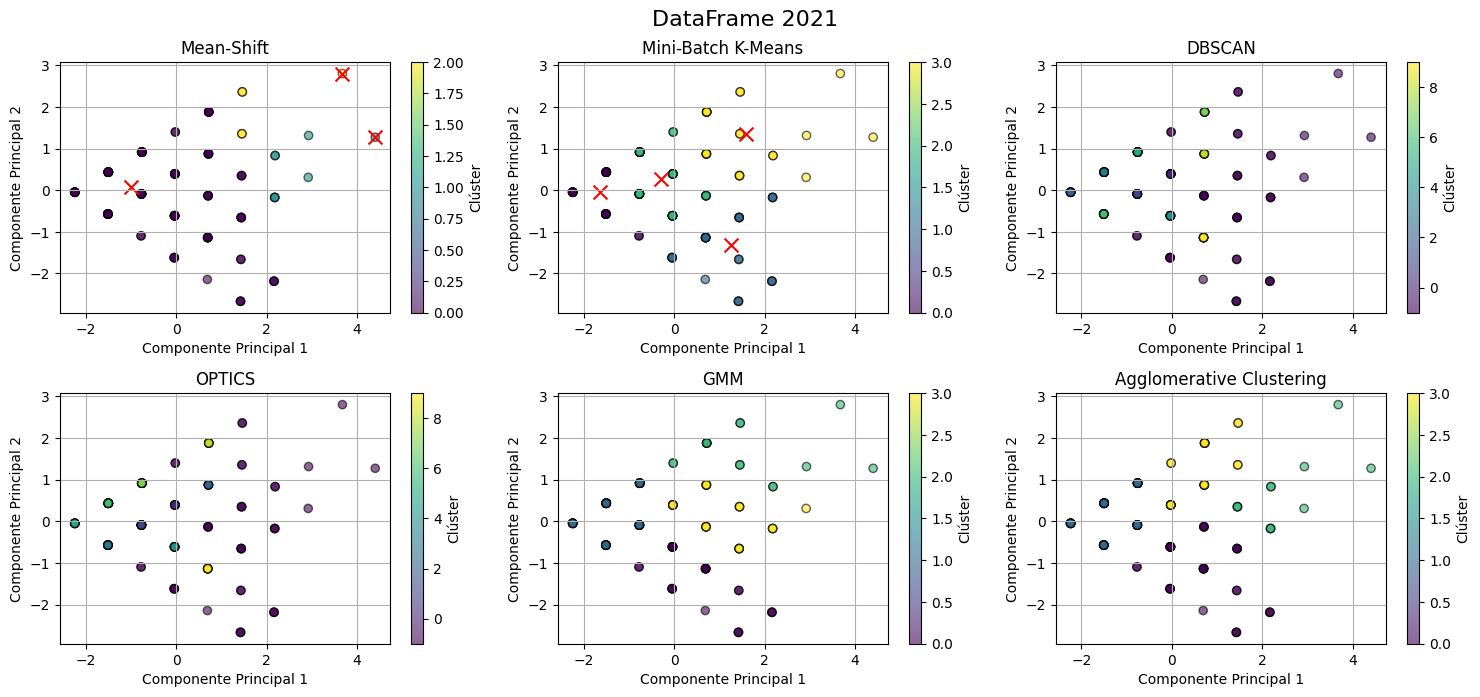

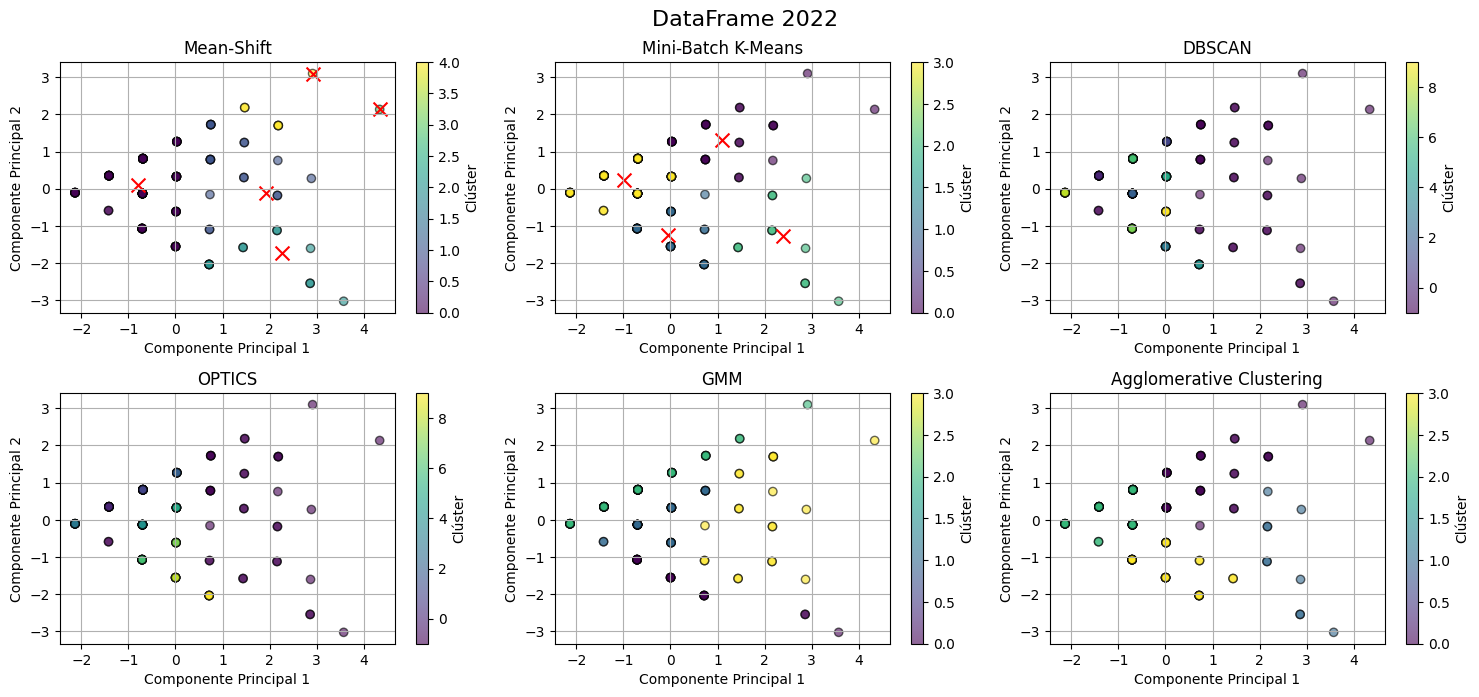

In [74]:
import warnings

# Desactivar RuntimeWarnings temporalmente
warnings.filterwarnings("ignore", category=RuntimeWarning)


# Definir los nombres de los algoritmos de clustering
algorithms = {
    "Mean-Shift": MeanShift(),
    "Mini-Batch K-Means": MiniBatchKMeans(n_clusters=4),
    "DBSCAN": DBSCAN(eps=0.5, min_samples=5),
    "OPTICS": OPTICS(),
    "GMM": GaussianMixture(n_components=4),
    "Agglomerative Clustering": AgglomerativeClustering(n_clusters=4)
}

# Iterar sobre cada DataFrame
for i, df in enumerate(csvs):
    # Reducción de dimensionalidad con PCA
    scaler = StandardScaler()
    df_numeric = df.drop(columns=['Match Number', 'Round Number', 'Result', 'Winner', 'Home Team', 'Away Team'])
    df_scaled = scaler.fit_transform(df_numeric)
    pca = PCA(n_components=2)
    df_pca = pca.fit_transform(df_scaled)

    # Iterar sobre cada algoritmo de clustering
    plt.figure(figsize=(15, 10))
    plt.suptitle(f'DataFrame {i+2017}', fontsize=16)
    for j, (name, algorithm) in enumerate(algorithms.items(), 1):
        algorithm.fit(df_pca)
        if hasattr(algorithm, 'labels_'):
            labels = algorithm.labels_
        else:
            labels = algorithm.predict(df_pca)
        
        # Visualización de resultados
        plt.subplot(3, 3, j)
        plt.scatter(df_pca[:, 0], df_pca[:, 1], c=labels, cmap='viridis', edgecolor='k', alpha=0.6)
        plt.title(name)
        plt.xlabel('Componente Principal 1')
        plt.ylabel('Componente Principal 2')
        plt.colorbar(label='Clúster')
        if hasattr(algorithm, 'cluster_centers_'):
            plt.scatter(algorithm.cluster_centers_[:, 0], algorithm.cluster_centers_[:, 1], c='red', marker='x', s=100)
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Reactivar RuntimeWarnings
warnings.filterwarnings("default", category=RuntimeWarning)

Con toda esta información podemos visualizar un patrón en cada Champions pasada. Lo primero es identificar que nos está diciendo cada gráfica. Cuando se utiliza PCA (Análisis de Componentes Principales) para reducir la dimensionalidad de los datos, los componentes principales se denominan comúnmente "Componente Principal 1" (PC1) y "Componente Principal 2" (PC2), y se refieren a las nuevas dimensiones que se crean después de la reducción de dimensionalidad. Son combinaciones lineales de las características originales en los datos y representan direcciones en el espacio de características donde los datos tienen la mayor variabilidad.

Por lo tanto, cuando se visualizan los datos en un gráfico de dispersión utilizando PC1 y PC2 en los ejes x e y estamos viendo cómo los datos se distribuyen en el espacio definido por estas dos direcciones de máxima variabilidad.

En este caso los algoritmos en los que nos vamos a centrar son K-means, Mini-Batch K-means, GMM y Agglomerative Clustering. Estos algoritmos son los que nos proporcionan un patrón más claro de separación entre clusteres, cada uno con su propia definición.

Analizando

Proseguimos llevando a cabo el mismo estudio pero esta vez asociado al ranking UEFA y los goles de cada equipo los últimos 7 años:

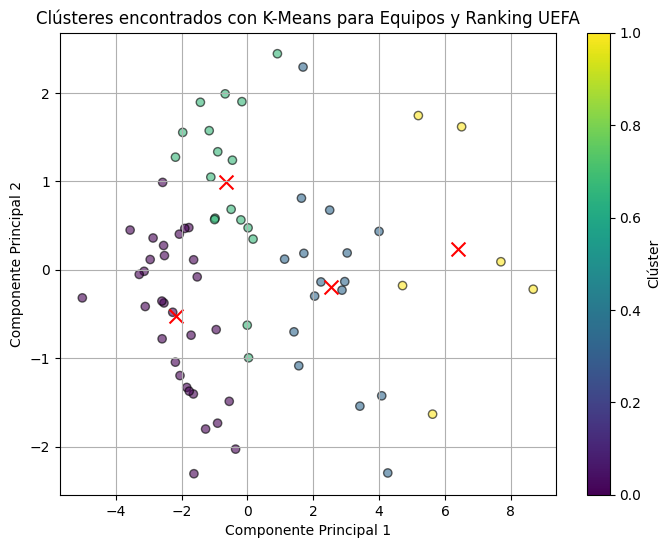

In [75]:
# Renombrar columna en df_equipos_goles
df_equipos_goles.rename(columns={'Equipo': 'Club'}, inplace=True)

# Unir los DataFrames en base a la columna 'Club'
df_combined = pd.merge(df_equipos_goles, df_uefa_ranking, on='Club')

# Eliminar la columna 'Club' antes de aplicar PCA
df_combined_numeric = df_combined.drop(columns=['Club'])

# Imputar valores perdidos con 0
imputer = SimpleImputer(strategy='constant', fill_value=0)
df_imputed = imputer.fit_transform(df_combined_numeric)

# Escalar características numéricas
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_imputed)

# Reducción de dimensionalidad con PCA
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)

# Clústering con K-Means
kmeans = KMeans(n_clusters=4)
kmeans.fit(df_pca)
labels = kmeans.labels_

# Visualización de resultados
plt.figure(figsize=(8, 6))
plt.scatter(df_pca[:, 0], df_pca[:, 1], c=labels, cmap='viridis', edgecolor='k', alpha=0.6)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='x', s=100)
plt.title('Clústeres encontrados con K-Means para Equipos y Ranking UEFA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar(label='Clúster')
plt.grid(True)
plt.show()

Probamos también con los demás algortimos para posteriormente sacar las conclusiones necesarias:

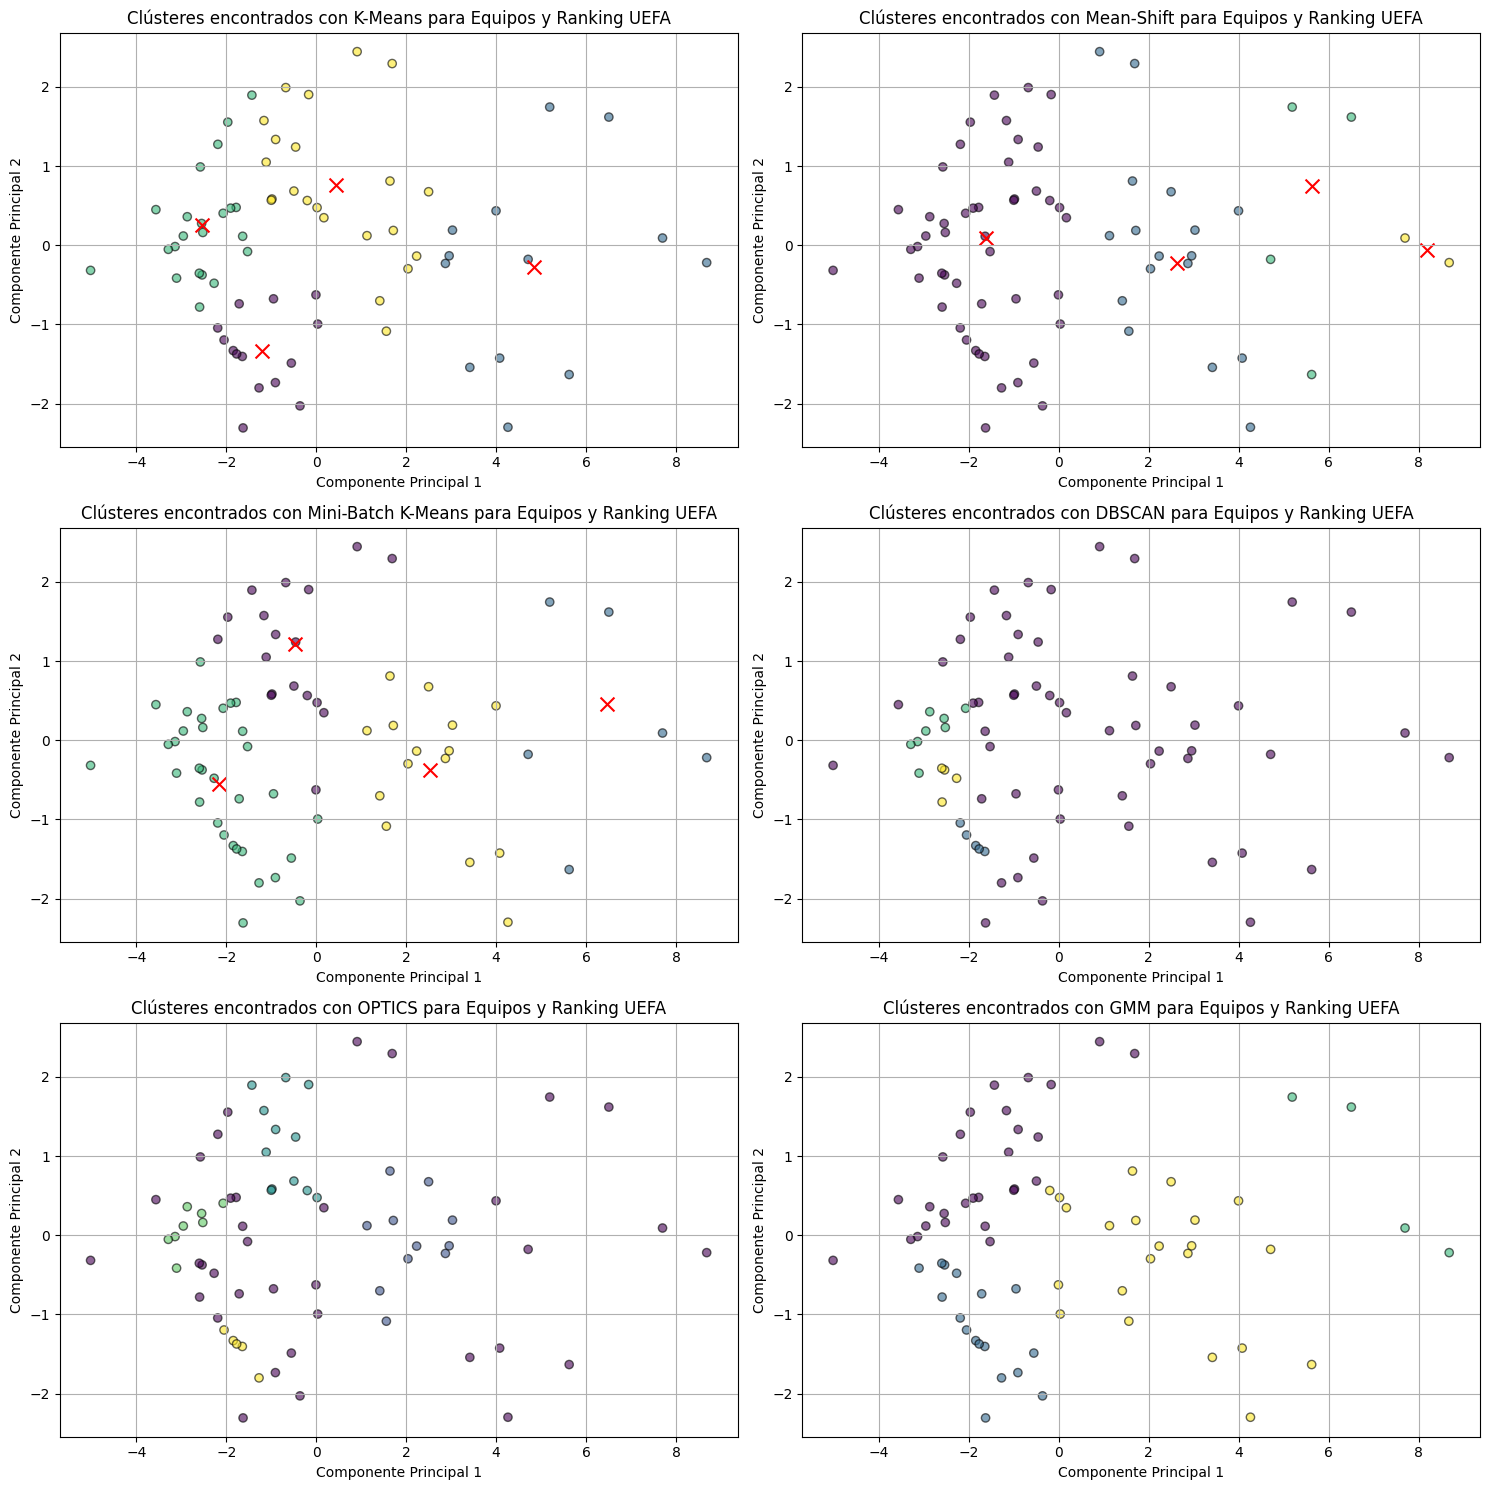

In [79]:
# Diccionario de algoritmos de clústering
algorithms = {
    "K-Means": KMeans(n_clusters=4),
    "Mean-Shift": MeanShift(),
    "Mini-Batch K-Means": MiniBatchKMeans(n_clusters=4),
    "DBSCAN": DBSCAN(eps=0.5, min_samples=5),
    "OPTICS": OPTICS(),
    "GMM": GaussianMixture(n_components=4),
    "Agglomerative Clustering": AgglomerativeClustering(n_clusters=4)
}

# Crear subgráficos para mostrar los resultados de todos los algoritmos en la misma ventana de visualización
fig, axs = plt.subplots(3, 2, figsize=(15, 15))
axs = axs.ravel()

for ax, (name, algorithm) in zip(axs, algorithms.items()):
    algorithm.fit(df_pca)
    if hasattr(algorithm, 'labels_'):
        labels = algorithm.labels_
    else:
        labels = algorithm.predict(df_pca)
    
    # Visualización de resultados
    ax.scatter(df_pca[:, 0], df_pca[:, 1], c=labels, cmap='viridis', edgecolor='k', alpha=0.6)
    if hasattr(algorithm, 'cluster_centers_'):
        ax.scatter(algorithm.cluster_centers_[:, 0], algorithm.cluster_centers_[:, 1], c='red', marker='x', s=100)
    ax.set_title(f'Clústeres encontrados con {name} para Equipos y Ranking UEFA')
    ax.set_xlabel('Componente Principal 1')
    ax.set_ylabel('Componente Principal 2')
    ax.grid(True)

plt.tight_layout()
plt.show()